In [1]:
!pip install -Uqq fastbook
!pip install kaggle
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.callback.fp16 import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 41.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
Mounted at /content/gdrive


##Get the data

Downloading the dataset:

In [2]:
!pip install kaggle
%cd /content/gdrive/MyDrive/Kaggle/

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

!kaggle datasets download -d lantian773030/pokemonclassification
#!kaggle datasets download -d thedagger/pokemon-generation-one

/content/gdrive/MyDrive/Kaggle
/content/gdrive/My Drive/Kaggle
Dataset URL: https://www.kaggle.com/datasets/lantian773030/pokemonclassification
License(s): copyright-authors
 97% 403M/417M [00:05<00:00, 23.3MB/s]
100% 417M/417M [00:05<00:00, 76.2MB/s]


Unzip the data and remove the zip file

In [3]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: PokemonData/Golbat/78bb8cd2828f40158fc0dcd4c0366a57.jpg  
  inflating: PokemonData/Golbat/7b7a064d3a1b4c53a9be936d4e4e3bab.jpg  
  inflating: PokemonData/Golbat/7d07fd6776fb40e9986a1a0f62233325.jpg  
  inflating: PokemonData/Golbat/815b279060b94e12a6b35d434a5250c2.jpg  
  inflating: PokemonData/Golbat/818014085ff04885b31eb5e8737012f2.jpg  
  inflating: PokemonData/Golbat/87529331a47b4a5cb5d10a6b3ea46d84.jpg  
  inflating: PokemonData/Golbat/914fab74d32e49a98940d5ba7f674fa6.jpg  
  inflating: PokemonData/Golbat/949a05bd0ad44be993e5fd89a8f582df.jpg  
  inflating: PokemonData/Golbat/9a4c793b9b0042a99ebd540897f9f898.jpg  
  inflating: PokemonData/Golbat/a35b4e8e603c485cb197520af30e1208.jpg  
  inflating: PokemonData/Golbat/a45a14a67a7348bba57c06467bb73cde.jpg  
  inflating: PokemonData/Golbat/acc2b44eada74a25a64c041b2e80c453.jpg  
  inflating: PokemonData/Golbat/af30483e382240d38890dec39e083b08.jpg  

## Prepare dataset

The dataset contains .svg and other image file types that might cause errors, so let's limit our image files to .jpg and .jpeg files only.

**Data augmentation**

I'm adding mult=1.5 to amplify batch transformation effects. Don't pick a number that's too big because it might distort your images too much.

In [4]:
path = '/content/gdrive/MyDrive/Kaggle/PokemonData'

def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=partial(get_files, extensions=['.jpg','.jpeg']),
                   get_y=parent_label,
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75, mult=1.5),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs) #num_workers=0 for windows.


bs=512 makes the model less accurate and didn't improve training speedd at all.
Size 32 or 64 don't reduce learning time

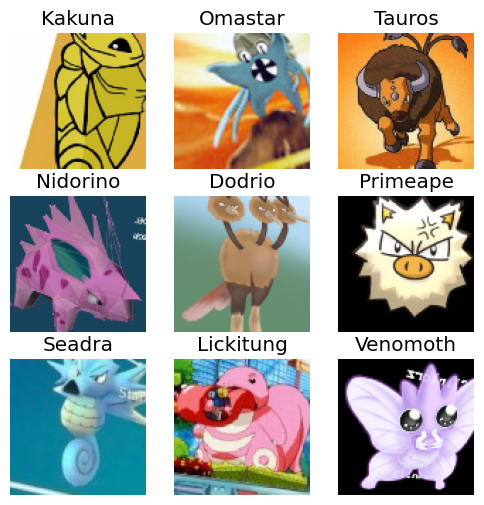

In [5]:
dls = get_dls(64, 96)
dls.train.show_batch(figsize=(6,6))

Let's view our data augmentation results. If the transformation results are too extreme, it can be reduced by reducing mult variable from DataBlock API.

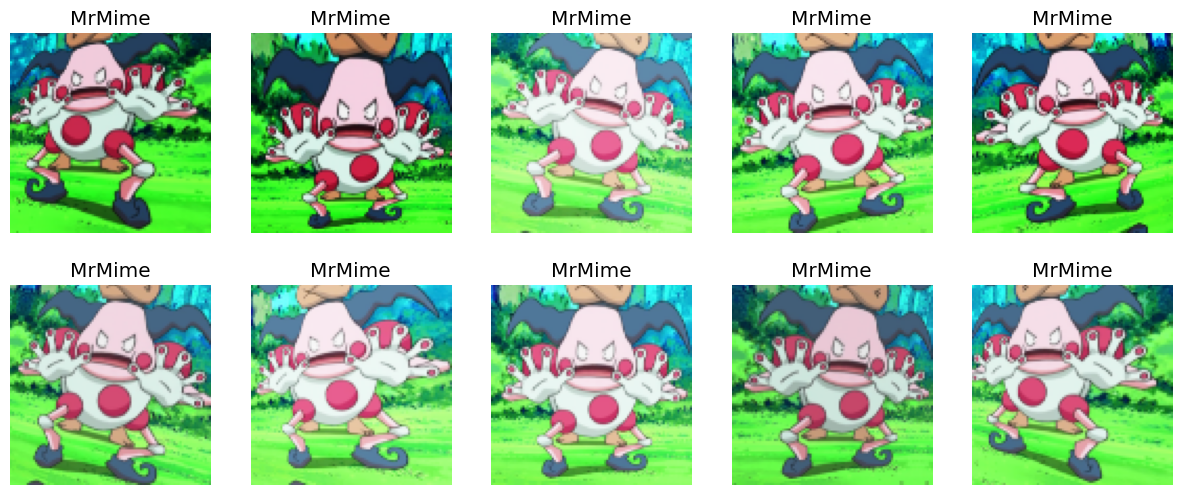

In [6]:
dls.train.show_batch(max_n=10, nrows=2, unique=True)

## Model training (from scratch)

Find an acceptable learning rate

SuggestedLRs(valley=0.00019054606673307717)

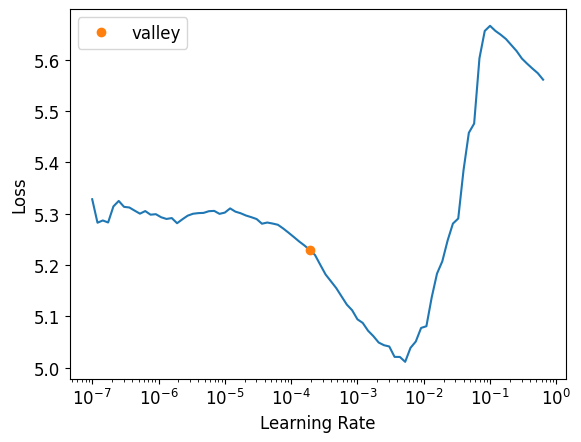

In [7]:
learn = Learner(dls, xresnet152(n_out=dls.c), metrics=accuracy).to_fp16()
lr_min = learn.lr_find()
lr_min

Fit the model with a learning rate of 0.001 (best learning rate from our learning rate optimization)

In [8]:
learn.fit_one_cycle(10,0.001)

epoch,train_loss,valid_loss,accuracy,time
0,4.450203,4.105091,0.083645,01:56
1,3.807400,3.597092,0.147125,01:45
2,3.333097,3.525866,0.211352,01:45
3,2.787882,2.827176,0.300971,01:48
4,2.274744,2.245892,0.418969,01:43
5,1.804921,1.867293,0.494399,01:45
6,1.433775,1.534488,0.600448,01:44
7,1.059046,1.324908,0.658701,01:45
8,0.852408,1.210161,0.681852,01:44
9,0.727099,1.199840,0.687080,01:43


Inference on uploaded files

In [9]:
from google.colab import files
uploaded = files.upload()

Saving doduo.png to doduo.png


In [18]:
learn.predict('/content/gdrive/MyDrive/Kaggle/doduo.png')

('Doduo',
 tensor(25),
 tensor([2.6925e-04, 3.1474e-05, 5.7440e-05, 3.7738e-06, 6.5855e-05, 5.4925e-04, 5.5874e-07, 9.3234e-05, 1.1401e-04, 1.8112e-04, 5.5991e-06, 1.7174e-07, 7.2895e-05, 6.0070e-06, 3.3575e-04, 1.1535e-04,
         6.7925e-07, 7.1057e-06, 4.3527e-05, 2.4365e-06, 6.8088e-04, 2.4608e-05, 3.5676e-03, 1.9090e-05, 2.9236e-02, 7.2654e-01, 5.4596e-05, 8.1958e-05, 1.9315e-05, 8.2924e-05, 2.5571e-03, 2.0914e-02,
         2.0163e-05, 5.0889e-05, 1.6168e-06, 5.5773e-06, 1.0494e-03, 3.2826e-03, 1.4014e-02, 1.0879e-04, 3.8034e-06, 7.6969e-07, 2.0120e-03, 8.7244e-05, 4.1285e-06, 1.4268e-06, 3.6369e-05, 1.3200e-04,
         1.4051e-04, 1.1025e-06, 2.3169e-03, 1.7179e-05, 7.8346e-06, 2.6464e-02, 5.8029e-02, 4.1534e-05, 7.5503e-05, 7.4758e-06, 7.8795e-07, 1.9622e-04, 3.0561e-06, 7.3686e-03, 3.2141e-02, 1.2255e-04,
         3.7608e-03, 2.2435e-03, 1.0815e-04, 1.9350e-06, 1.2113e-04, 1.4242e-05, 1.4021e-05, 5.7440e-05, 7.3837e-04, 2.0847e-04, 2.0166e-04, 3.2473e-05, 1.5581e-05, 2.3208e-

Gets the correct answer!

## **Using MixUp**

SuggestedLRs(valley=0.0002290867705596611)

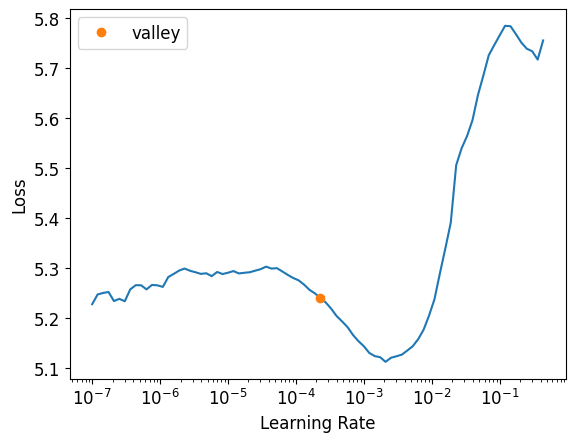

In [19]:
learn2 = Learner(dls, xresnet152(n_out=dls.c), metrics=accuracy, cbs=MixUp()).to_fp16()
lr_min2 = learn2.lr_find()
lr_min2

In [20]:
learn2.fit_one_cycle(20, 0.003162)

epoch,train_loss,valid_loss,accuracy,time
0,4.529360,4.099136,0.098581,01:42
1,4.297700,4.579882,0.087379,01:41
2,4.257277,3.754138,0.156087,01:40
3,3.949226,3.695889,0.151606,01:41
4,3.631406,3.347021,0.230022,01:43
5,3.253067,2.526609,0.351755,01:41
6,2.994735,2.462532,0.363704,01:40
7,2.775767,2.344499,0.386109,01:43
8,2.550180,1.841778,0.522778,01:41
9,2.352555,1.588545,0.590739,01:43


Inference with uploaded files

In [21]:
from google.colab import files
uploaded = files.upload()

Saving dugtrio.jpg to dugtrio.jpg


In [22]:
learn.predict('/content/gdrive/MyDrive/Kaggle/dugtrio.jpg')

('Dugtrio',
 tensor(30),
 tensor([5.0250e-06, 1.2292e-05, 1.5717e-07, 1.3443e-07, 8.5967e-07, 1.6477e-03, 8.4127e-08, 5.3058e-08, 6.4135e-07, 3.3353e-04, 1.4089e-07, 3.5344e-08, 1.2828e-07, 5.3454e-04, 3.3736e-06, 8.6148e-06,
         3.2698e-06, 7.7965e-04, 3.5613e-03, 2.4726e-07, 1.6967e-03, 3.9822e-07, 1.5670e-01, 5.4121e-06, 2.5320e-05, 1.4275e-03, 1.0451e-06, 4.3149e-06, 5.0644e-06, 2.6359e-04, 3.9858e-01, 6.4039e-04,
         1.2362e-06, 8.8164e-08, 2.9772e-06, 5.0807e-04, 4.8151e-04, 7.4661e-03, 9.8399e-05, 1.4427e-05, 1.0976e-05, 1.8958e-07, 1.1916e-04, 8.6824e-06, 4.2061e-07, 1.7949e-07, 2.0108e-05, 1.7818e-03,
         1.1504e-04, 4.9471e-06, 4.6442e-04, 2.9826e-07, 6.4774e-06, 1.7376e-02, 2.0840e-01, 1.5233e-07, 5.7370e-08, 4.5835e-07, 4.5581e-05, 1.2801e-08, 2.9487e-05, 3.9608e-04, 3.2639e-05, 7.3245e-07,
         1.4203e-05, 6.8456e-02, 1.1867e-05, 1.7917e-06, 1.2101e-05, 5.5956e-05, 1.6837e-04, 5.5504e-07, 1.0090e-06, 8.7176e-05, 5.0159e-05, 1.1256e-06, 2.4778e-06, 1.9222

Correct prediction!

## **Using pretrained models**

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 154MB/s]


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


SuggestedLRs(valley=0.0020892962347716093)

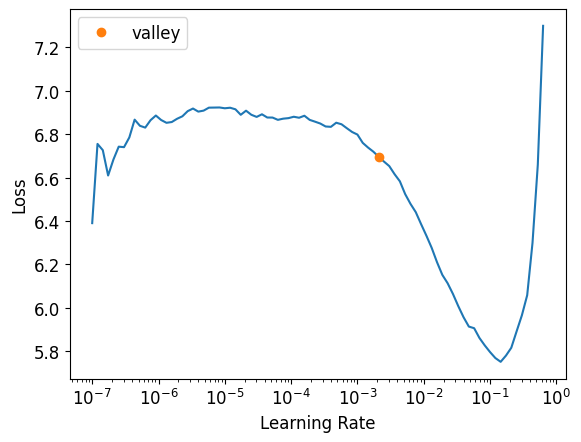

In [23]:
learn3 = vision_learner(dls, resnet152, metrics=accuracy)
lr_min3 = learn3.lr_find()
lr_min3

In [24]:
learn3.fit_one_cycle(20, 0.003162)

epoch,train_loss,valid_loss,accuracy,time
0,5.934096,4.110240,0.163555,01:42
1,3.924112,2.235613,0.517550,01:39
2,2.312051,1.668099,0.665422,01:39
3,1.393110,0.980403,0.754294,01:40
4,0.912289,0.836625,0.802091,01:40
5,0.655205,0.721067,0.824496,01:41
6,0.526861,0.743269,0.834205,01:38
7,0.416444,0.656408,0.840179,01:39
8,0.355417,0.670236,0.852128,01:38
9,0.303370,0.763088,0.866318,01:38


We get a better performance (above 89%)

## **Fine tuning with bigger images**

SuggestedLRs(valley=0.00363078061491251)

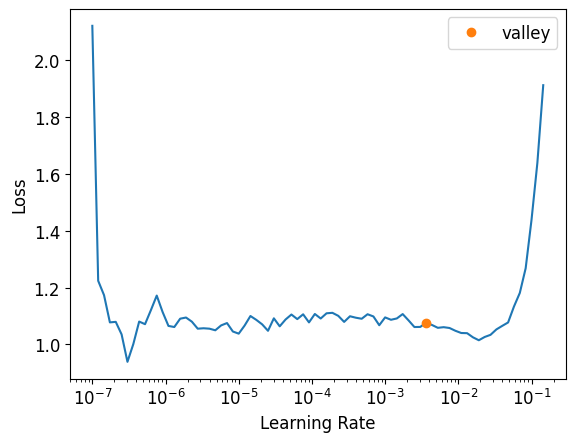

In [25]:
best_learner = learn3
best_learner.dls = get_dls(16, 224)
lr_min_final = best_learner.lr_find()
lr_min_final

In [26]:
best_learner.fine_tune(10, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,1.878679,1.125165,0.774459,02:33


epoch,train_loss,valid_loss,accuracy,time
0,0.597025,0.319408,0.914115,03:11
1,0.945593,0.589732,0.867065,03:09
2,1.080684,0.727316,0.829724,03:09
3,0.908993,0.567427,0.864078,03:09
4,0.552775,0.522197,0.891710,03:08
5,0.354099,0.355685,0.926064,03:10
6,0.224122,0.255065,0.946975,03:07
7,0.136314,0.267371,0.945482,03:07
8,0.086986,0.234621,0.950709,03:08
9,0.068735,0.228753,0.953697,03:07


Ovr 95% accuracy

## Using test-Time Augmentation (TTA)

In [27]:
preds,targs = best_learner.tta()
accuracy(preds, targs).item()

0.9634055495262146

TTA squeezes 2% accuracy more

## Let's test the model

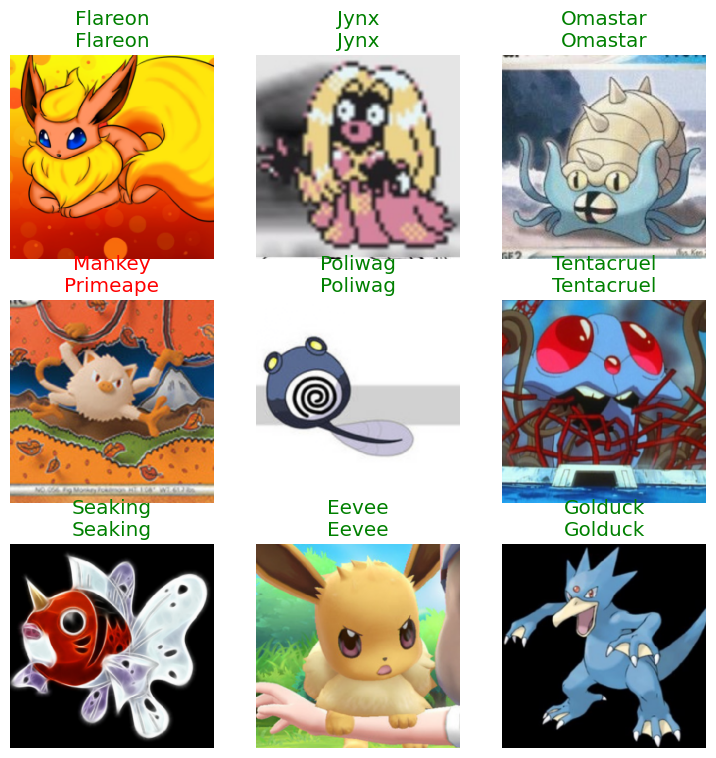

In [28]:
best_learner.show_results()

Let's see the most faulty predictions

In [29]:
interp = ClassificationInterpretation.from_learner(best_learner)
interp.most_confused(min_val=3)

[('Kingler', 'Krabby', 4),
 ('Kadabra', 'Alakazam', 3),
 ('Marowak', 'Cubone', 3)]

The classifier get's confused by the Pokemon with similar evolution forms. Let's look at the confusion matrix.

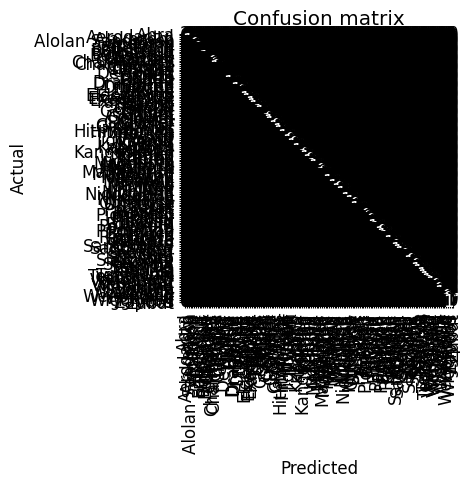

In [30]:
interp = ClassificationInterpretation.from_learner(best_learner)
interp.plot_confusion_matrix()

Too many labels, can't see anything

In [32]:
interp.most_confused(min_val=1)

[('Kingler', 'Krabby', 4),
 ('Kadabra', 'Alakazam', 3),
 ('Marowak', 'Cubone', 3),
 ('Cubone', 'Marowak', 2),
 ('Dewgong', 'Geodude', 2),
 ('Muk', 'Grimer', 2),
 ('Slowbro', 'Slowpoke', 2),
 ('Abra', 'Mew', 1),
 ('Aerodactyl', 'Nidorino', 1),
 ('Cubone', 'Geodude', 1),
 ('Exeggcute', 'Nidorino', 1),
 ('Exeggcute', 'Slowpoke', 1),
 ('Gastly', 'Cloyster', 1),
 ('Gengar', 'Haunter', 1),
 ('Golduck', 'Machamp', 1),
 ('Graveler', 'Onix', 1),
 ('Graveler', 'Rhydon', 1),
 ('Grimer', 'Muk', 1),
 ('Grimer', 'Shellder', 1),
 ('Growlithe', 'Vulpix', 1),
 ('Horsea', 'Golduck', 1),
 ('Horsea', 'Seadra', 1),
 ('Hypno', 'Dodrio', 1),
 ('Hypno', 'Farfetchd', 1),
 ('Jolteon', 'Zapdos', 1),
 ('Jynx', 'Mew', 1),
 ('Machamp', 'Scyther', 1),
 ('Mankey', 'Primeape', 1),
 ('Metapod', 'Geodude', 1),
 ('Muk', 'Shellder', 1),
 ('Nidoqueen', 'Golduck', 1),
 ('Ninetales', 'Ponyta', 1),
 ('Onix', 'Geodude', 1),
 ('Persian', 'Clefairy', 1),
 ('Persian', 'Rattata', 1),
 ('Pidgeot', 'Fearow', 1),
 ('Pidgeot', 'Pidgeo